In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import torch, torchvision
from torch import nn
from pathlib import Path
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
from typing import List, Tuple, Dict
from skimage import io, transform, color
from torchvision.transforms import functional as F

!pip install elasticdeform
import elasticdeform

import random

import cv2

from PIL import Image

import numpy as np

import multiprocessing as mp


#### To unlock to check the integrity of the dataset. Are there differences between images and masks?
"""
def checkDataset(img_path, mask_path):
  file_set1 = set()
  for dirpath, dirnames, filenames in os.walk(img_path):
    for filename in filenames:
      file_name, file_extension = os.path.splitext(filename)
      file_set1.add(file_name)

  file_set2 = set()
  for dirpath, dirnames, filenames in os.walk(mask_path):
    for filename in filenames:
      file_name, file_extension = os.path.splitext(filename)
      file_set2.add(file_name)

  # compare the sets of file names
  unique_to_folder1 = file_set1 - file_set2
  unique_to_folder2 = file_set2 - file_set1


  # print the results
  print("Files unique to folder 1:", unique_to_folder1)
  print("Files unique to folder 2:", unique_to_folder2)

"""


# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"


def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

data_path = Path("/content/gdrive/MyDrive/FoodSeg103/Images/")

img_dir = data_path / "img_dir"
ann_dir = data_path / "ann_dir"


# RandomCustomCrop
class RandomCustomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        img, mask = sample['image'], sample['mask']

        w = img.shape[0]
        h = img.shape[1]

        #print("w", w)
        #print("h", h)

        # New crop size passed in the constructor
        new_w, new_h = self.output_size

        if h == new_h and w == new_w:
            return sample

        if w < new_w or h < new_h:
            raise ValueError("Input image size is smaller than the desired crop size")
         #   #return sample

        x1 = random.randint(0, w - new_w)
        y1 = random.randint(0, h - new_h)

        # Convert to PIL Image
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        # Crop img and mask
        img = F.crop(img, y1, x1, new_h, new_w)
        mask = F.crop(mask, y1, x1, new_h, new_w)

        # PIL to numpy array
        img = np.array(img)
        mask = np.array(mask)

        return {'image': img, 'mask': mask}


# RandomCustomRotation
class RandomCustomRotation(object):


    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, sample):

        img, mask = sample['image'], sample['mask']

        angle = random.uniform(self.degrees[0], self.degrees[1])

        # Convert to PIL Image
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        # Rotation
        img = F.rotate(img, angle)
        mask = F.rotate(mask, angle)

        # PIL to numpy array
        img = np.array(img)
        mask = np.array(mask)

        return {'image': img, 'mask': mask}


# RandomCustomHorizontalFlip
class RandomCustomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']

        #print("img s", img.shape)
        #print("mask s", mask.shape)

        if random.random() < self.p:

            # Transformation to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).float()

            img = torch.flip(img, dims=[1])
            mask = torch.flip(mask, dims=[1])

            # Transform back
            img = img.numpy()
            mask = mask.numpy()

        return {'image': img, 'mask': mask}


# RandomCustomVerticalFlip
class RandomCustomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']

        #print("img s", img.shape)
        #print("mask s", mask.shape)

        if random.random() < self.p:

            # Transformation to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).float()

            img = torch.flip(img, dims=[0])
            mask = torch.flip(mask, dims=[0])

            # Transform back
            img = img.numpy()
            mask = mask.numpy()

        return {'image': img, 'mask': mask}



class RandomGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
      self.mean = mean
      self.std  = std

    def __call__(self, img):

      # Generate Gaussian noise with mean 0 and standard deviation 10 for each color channel
      noise = np.random.normal(0, 1, img.shape)

      # Scale the noise by a small factor (e.g., 0.05) to add a light layer of noise
      scaled_noise = 0.1 * noise

      # Add the noise to each color channel of the image
      noisy_img = np.clip(img.astype(np.int16) + scaled_noise, 0, 255).astype(np.uint8)

      img = noisy_img

      # Transform back
      #img = img.numpy()


      return img


# ElasticDeform
class ElasticDeform(object):
    def __init__(self, sigma, alpha):
        self.sigma = sigma
        self.alpha = alpha

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']

        #print(img.shape)
        #print(mask.shape)

        # We add a dimension at the end
        mask = np.expand_dims(mask, axis=-1)



        # Ensure that the input image is a 3D array with shape (height, width, channels)
        assert img.ndim == 3 and img.shape[2] == 3, "Input image must be a 3D RGB array with shape (height, width, 3)"

        # Ensure that the mask is a 3D array with shape (height, width, 1)
        assert mask.ndim == 3 and mask.shape[2] == 1, "Mask must be a 3D array with shape (height, width, 1)"

        # Reshape the input image into a 2D array with shape (height * width, channels)
        height, width, channels = img.shape
        flattened_img = img.reshape(-1)

        mask_rgb = np.repeat(mask, 3, axis=-1)
        flattened_mask = mask_rgb.reshape(-1)


        # Generate a random displacement field along the width and height dimensions
        #displacement = np.random.randn(2, height, width) * self.sigma

        # Combine images and masks into a single 3D array
        combined = np.concatenate((flattened_img, flattened_mask), axis=-1)

        # Apply deformation to combined array
        deformed_combined = elasticdeform.deform_random_grid(combined,
                                                     sigma=self.sigma,
                                                     order=3,
                                                     mode='nearest'
                                                     )

        # Split deformed array back into images and masks
        deformed_reshaped_img = deformed_combined[:height*width*channels].reshape((height, width, channels))
        deformed_reshaped_mask = deformed_combined[height*width*channels:].reshape((height, width, channels))

        #Convert mask to grayscale
        deformed_reshaped_mask = np.mean(deformed_reshaped_mask, axis=-1)
        deformed_reshaped_mask = np.expand_dims(deformed_reshaped_mask, axis=-1)

        #deformed_mask = np.squeeze(deformed_reshaped_mask, axis=-1)

        deformed_img = deformed_reshaped_img
        deformed_mask = deformed_reshaped_mask

        print("deformed_img", deformed_img.shape)
        print("deformed_mask", deformed_mask.shape)

        return {'image': deformed_img, 'mask': deformed_mask}




class CustomToTensor(object):
    #Convert ndarrays in sample to Tensors.


    def __new__(self, sample):
        img, mask = sample['image'], sample['mask']

        mask = np.expand_dims(mask, axis=-1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))

        return {'image': torch.from_numpy(img).float(),
                'mask': torch.from_numpy(mask).float()}


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


# Class SegIngredientDataset
class SegIngredientsDataset(Dataset):

    def __init__(self, img_dir, mask_dir, path, img_transform, mask_transform, common_transform, eval):

        self.eval = eval

        self.img_dir = img_dir / path
        self.mask_dir = mask_dir / path

        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.common_transform = common_transform

        print(self.img_dir)

        # Traverses and prints directory details
        #walk_through_dir(img_dir)

        #walk_through_dir(mask_dir)

        self.img_list = []
        self.mask_list = []

        self.dirs = [self.img_dir, self.mask_dir]

        self.num_processes = min(mp.cpu_count(), len(self.dirs))

    # Return the instance
    def Get(self):
        return self

    # Method called by the processs to do parallelization
    def run(self, obj):
        pool = mp.Pool(self.num_processes)

        pool.daemon = False

        manager = mp.Manager()
        p_img_list = manager.list()
        p_mask_list = manager.list()

        pool.starmap(self.read_files_from_folder, [(self.img_dir, p_img_list, cv2.IMREAD_COLOR), (self.mask_dir, p_mask_list, cv2.IMREAD_GRAYSCALE)])

        self.img_list = p_img_list
        self.mask_list = p_mask_list

        pool.close()
        pool.join()

    # Subprocess reading in the 2 different folders at the same time
    def read_files_from_folder(self, folder_path, custom_list, imread_type):
        counter = 0
        for entry in sorted(os.scandir(folder_path), key=lambda e: e.name):
            if entry.is_file():
              img_path = entry.path

              img_open = Image.open(img_path)
              img_open = img_open.resize((256, 256), resample=Image.NEAREST)

              img_array = np.array(img_open)
              custom_list.append(img_array)
              #print(filename, " | ", np.unique(img_array))
              print(img_path)


            counter = counter + 1
            if(counter >17):
              break


    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        img = self.img_list[idx]
        y = self.mask_list[idx]


        # Create sample array to perform modifications simultaneously on both images and masks
        sample = {}
        sample['image'] = img
        sample['mask'] = y

        #print("start")

        if(self.eval):
          sample_transformed = CustomToTensor(sample)
          img = sample_transformed['image']
          y = sample_transformed['mask']

          #print("bonjour")
          #print(img.shape)
          #print(y.shape)
          #print("bonjour1")

          return img, y

        if self.img_transform and self.mask_transform and self.common_transform is not None:

            # Perform modifications together
            sample_transformed = self.common_transform(sample)
            img = sample_transformed['image']
            y = sample_transformed['mask']

            img = self.img_transform(img)
            y = self.mask_transform(y)


       # print("conclusion")
       # if self.eval:
       #     return img, y, self.img_list[idx]
       # else:
        return img, y


# Parallelization

from multiprocessing import Process, Manager
from multiprocessing.managers import BaseManager

BaseManager.register('SegIngredientsDataset', SegIngredientsDataset)
manager = BaseManager()
manager.start()

#####
#Transformations
#########


#Normalization image

img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

#mask_mean = (0.5,)
#mask_std = (0.5,)


#RandomGaussianNoise(mean=0.0, std=1.0),
img_transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

# Mask transform
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Common transform
#RandomCustomCrop((200,200)),
#RandomCustomRotation(degrees=(-50, 50)),

#RandomCustomVerticalFlip(),
#ElasticDeform(sigma=0.1, alpha=30),
common_transform = transforms.Compose([

    RandomCustomRotation(degrees=(-50, 50)),
    RandomCustomHorizontalFlip(),

])


# Classes handled by the process manager

train_data = manager.SegIngredientsDataset(img_dir = img_dir, mask_dir = ann_dir, path = "train/", img_transform=img_transform, mask_transform=mask_transform, common_transform=common_transform, eval=False)
test_data  = manager.SegIngredientsDataset(img_dir = img_dir, mask_dir = ann_dir, path = "test/", img_transform=img_transform, mask_transform=mask_transform, common_transform=common_transform, eval=True)

process1 = mp.Process(target=train_data.run, args=[train_data])
process2 = mp.Process(target=test_data.run, args=[test_data])
process1.start()
process2.start()

process1.join()
process2.join()

# Retrieve the 2 datasets (train and test)
train_1 = train_data.Get()
test_1 = test_data.Get()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 2.2 MB/s eta 0:00:00
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test/00000048.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/test/00000048.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test/00000263.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/test/00000263.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test/00001977.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/test/00001977.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test/00002106.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/test/00002106.png
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/test/00004401.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test/00004401.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/test/00004402.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/test/000044

In [ ]:
# Calculate pixel accuracy
def calculate_pixel_accuracy(y_truth, y_pred):

    matched_pixels = (y_truth == y_pred).sum().item()
    total_pixels = y_truth.nelement()
    #print("matched pixels", matched_pixels)
    match_ = (matched_pixels / total_pixels)

    return match_



Feature batch shape: torch.Size([4, 3, 256, 256])
Labels batch shape: torch.Size([4, 1, 256, 256])
torch.Size([3, 256, 256])


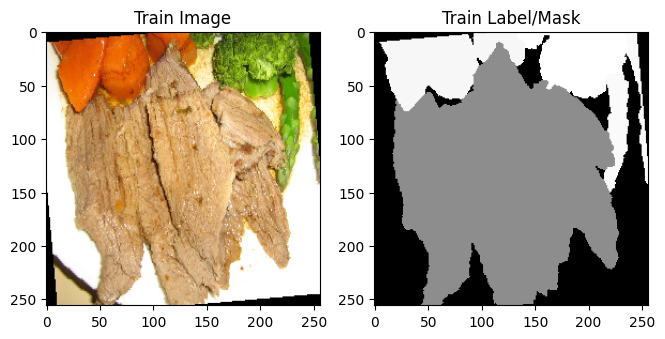

In [ ]:
# We create a train_loader by passing the train dataset
train_loader = torch.utils.data.DataLoader(dataset = train_1,
                                            batch_size = 4,
                                            shuffle = True,
                                            drop_last=True) #shuffle ensures we traverse images in different order across epochs


# Display image and label. Checking if everything is fine
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Remove extra dimension (batch)
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
print(img.size())

#print(label)


# Unnormalize the data so it appears clearly:

img_unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#mask_unnorm = UnNormalize(mean=(0.5,), std=(0.5,))

img_new = img_unnorm(img)
#mask_unnorm = mask_unnorm(label)

img_new = img_new.permute(1,2,0)

#print(img_new)





# normalize the tensor values to the range [0, 255]
img_new = img_new * 255.0

# convert the tensor to a numpy array
img_new = img_new.clamp(0, 255).byte().numpy()

#print(img_new)

"""
Label

"""

# normalize the tensor values to the range [0, 255]
label_new = label * 255.0

# convert the tensor to a numpy array
label_new = label_new.clamp(0, 255).byte().numpy()

#print(label_new)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Train Image')
plt.imshow(img_new)
plt.subplot(232)
plt.title('Train Label/Mask')
plt.imshow(label_new, cmap="gray")

plt.show()


del train_loader


In [ ]:
#if not FIRST_RUN:
#  del train_step

def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
optimizer: torch.optim.Optimizer):
  total_train = 0
  correct_train = 0
# Put model in train mode
  model.train()
# Setup train loss and train accuracy values
  train_loss, train_acc, train_miou_acc_all, train_dice_acc, train_miou_acc_ibg, train_iou_background = 0, 0, 0, 0, 0, 0
# Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    y = y.squeeze(dim=1)
    y = y.type(torch.LongTensor)
    #X = X.float()

    #print("y", y.shape )


# Send data to target device
    X, y = X.to(device), y.to(device)
# 1. Forward pass
    y_pred = model(X)
    #print("y pred shape", y_pred.shape)
# 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
# 3. Optimizer zero grad
    optimizer.zero_grad()
# 4. Loss backward
    loss.backward()
# 5. Optimizer step
    optimizer.step()
# Calculate and accumulate accuracy metric across all batches

    predicted = torch.argmax(y_pred, 1)

    train_acc += calculate_pixel_accuracy(y, predicted)

    train_tp, train_fp, train_fn, train_tn = smp.metrics.get_stats(predicted, y, mode='multiclass', num_classes=104)
    train_miou_acc_all += smp.metrics.iou_score(train_tp, train_fp, train_fn, train_tn, reduction="micro").item()
    train_dice_acc += smp.metrics.f1_score(train_tp, train_fp, train_fn, train_tn, reduction="micro").item()

    predicted_i = predicted.clone() - 1
    y_i = y.clone() - 1

    train_tp_i, train_fp_i, train_fn_i, train_tn_i = smp.metrics.get_stats(predicted_i, y_i, mode='multiclass', num_classes=104, ignore_index=-1)
    train_miou_acc_ibg += smp.metrics.iou_score(train_tp_i, train_fp_i, train_fn_i, train_tn_i, reduction="micro").item()




# Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)

  train_acc = train_acc / len(dataloader)

  train_miou_acc_all = train_miou_acc_all / len(dataloader)
  train_dice_acc = train_dice_acc / len(dataloader)

  train_miou_acc_ibg = train_miou_acc_ibg / len(dataloader)

  train_iou_background = train_miou_acc_all - train_miou_acc_ibg


  return train_loss, train_acc, train_miou_acc_all, train_dice_acc, train_miou_acc_ibg, train_iou_background


In [ ]:
#if not FIRST_RUN:
#  del test_step

def test_step(model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module):

  total_test = 0
  correct_test = 0
# Put model in eval mode
  model.eval()
# Setup test loss and test accuracy values
  test_loss, test_acc, test_miou_acc_all, test_dice_acc, test_miou_acc_ibg, test_iou_background = 0, 0, 0, 0, 0, 0
# Turn on no_grad context manager
  with torch.no_grad():
# Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      y = y.squeeze(dim=1)
      y = y.type(torch.LongTensor)

# Send data to target device
      X, y = X.to(device), y.to(device)
# 1. Forward pass
      test_pred_logits = model(X)
# 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
# Calculate and accumulate accuracy

      predicted = torch.argmax(test_pred_logits, 1)

      test_acc += calculate_pixel_accuracy(y, predicted)

      test_tp, test_fp, test_fn, test_tn = smp.metrics.get_stats(predicted, y, mode='multiclass', num_classes=104)
      test_miou_acc_all += smp.metrics.iou_score(test_tp, test_fp, test_fn, test_tn, reduction="micro").item()
      test_dice_acc += smp.metrics.f1_score(test_tp, test_fp, test_fn, test_tn, reduction="micro").item()

      predicted_i = predicted.clone() - 1
      y_i = y.clone() - 1

      test_tp_i, test_fp_i, test_fn_i, test_tn_i = smp.metrics.get_stats(predicted_i, y_i, mode='multiclass', num_classes=104, ignore_index=-1)
      test_miou_acc_ibg += smp.metrics.iou_score(test_tp_i, test_fp_i, test_fn_i, test_tn_i, reduction="micro").item()




# Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)

  test_acc = test_acc / len(dataloader)

  test_miou_acc_all = test_miou_acc_all / len(dataloader)
  test_dice_acc = test_dice_acc / len(dataloader)

  test_miou_acc_ibg = test_miou_acc_ibg / len(dataloader)

  test_iou_background = test_miou_acc_all - test_miou_acc_ibg

  return test_loss, test_acc, test_miou_acc_all, test_dice_acc, test_miou_acc_ibg, test_iou_background


In [ ]:
#if not FIRST_RUN:
#  del save_training_checkpoint
#  del save_results_in_file
#  del train

import json

# Function to save pth files to google drive
def save_training_checkpoint(state, filename):
    path = F"/content/gdrive/MyDrive/Thesis_deeplearning_models/{filename}.pth"
    torch.save(state, path)

# Function to save results into a file
def save_results_in_file(dic_results, hyperparameters):
  link = "/content/gdrive/MyDrive/Thesis_deeplearning_models/results_randomsearch_v" + str(hyperparameters.VERSION_EXPERIMENT) + ".txt"
  with open(link, 'a') as f:
    json.dump(dic_results, f)
    f.write('\n')


# Define a custom encoder that skips over non-serializable attributes
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, property):
            return None
        return super().default(obj)


def save_hyperparameters_in_file(hyperparameters):
  # Convert the class variables to a dictionary
  table_dict = {"VERSION_EXPERIMENT": hyperparameters.VERSION_EXPERIMENT,
                "OPTIMIZER": hyperparameters.OPTIMIZER,
                "ARCHITECTURE_USED" : hyperparameters.ARCHITECTURE_USED,
                "NETWORK": hyperparameters.NETWORK,
                "BATCH_SIZE": hyperparameters.BATCH_SIZE,
                "LEARNING_RATE": hyperparameters.LEARNING_RATE,
                "MOMENTUM": hyperparameters.MOMENTUM,
                "WEIGHT_DECAY": hyperparameters.WEIGHT_DECAY,
                "LOSS_FUNCTION" : hyperparameters.LOSS_FUNCTION,
                "NUM_EPOCHS": hyperparameters.NUM_EPOCHS
                }

  # Serialize the dictionary to a JSON string
  json_string = json.dumps(table_dict, indent=4)
  json_string_comma = "," + json_string
  link = "/content/gdrive/MyDrive/Thesis_deeplearning_models/hyperparameters_versions.txt"

  # Write the JSON string to a text file
  with open(link, "a") as f:
    f.write(json_string_comma)



def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer, hyperparameters, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), epochs: int = 5):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "train_miou_acc_all": [],
        "train_dice_acc" : [],
        "train_miou_acc_ibg" : [],
        "train_iou_background": [],
        "test_loss": [],
        "test_acc": [],
        "test_miou_acc_all": [],
        "test_dice_acc": [],
        "test_miou_acc_ibg" : [],
        "test_iou_background": [],
        "learning_rate": [],
    }

    results_line = {
        "epoch": 0,
        "train_loss": 0,
        "train_acc": 0,
        "train_miou_acc_all": 0,
        "train_dice_acc" : 0,
        "train_miou_acc_ibg" : 0,
        "train_iou_background": 0,
        "test_loss": 0,
        "test_acc": 0,
        "test_miou_acc_all": 0,
        "test_dice_acc": 0,
        "test_miou_acc_ibg" : 0,
        "test_iou_background": 0,
        "learning_rate": 0,
    }

    # Save hyperparameters in a file
    save_hyperparameters_in_file(hyperparameters)

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_miou_acc_all, train_dice_acc, train_miou_acc_ibg, train_iou_background = train_step(model=model,dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc, test_miou_acc_all, test_dice_acc, test_miou_acc_ibg, test_iou_background = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        #current_lr = scheduler.get_last_lr()[0]
        #scheduler.step()
        current_lr = hyperparameters.LEARNING_RATE


        # 4. Print loss & accuracies
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_miou_acc_all: {train_miou_acc_all:.4f} | "
            f"train_dice_acc: {train_dice_acc:.4f} | "
            f"train_miou_acc_ibg: {train_miou_acc_ibg:.4f} | "
            f"train_iou_background: {train_iou_background:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"test_miou_acc_all: {test_miou_acc_all:.4f} | "
            f"test_dice_acc: {test_dice_acc:.4f} | "
            f"test_miou_acc_ibg: {test_miou_acc_ibg:.4f} | "
            f"test_iou_background: {test_iou_background:.4f} | "
            f"learning_rate: {current_lr:.4f} | "
        )
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_miou_acc_all"].append(train_miou_acc_all)
        results["train_dice_acc"].append(train_dice_acc)
        results["train_miou_acc_ibg"].append(train_miou_acc_ibg)
        results["train_iou_background"].append(train_iou_background)

        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_miou_acc_all"].append(test_miou_acc_all)
        results["test_dice_acc"].append(test_dice_acc)
        results["test_miou_acc_ibg"].append(test_miou_acc_ibg)
        results["test_iou_background"].append(test_iou_background)

        results["learning_rate"].append(current_lr)


        # Save model continuously :

        """file_checkpoint_exp = 'checkpoint_random_v' + str(hyperparameters.VERSION_EXPERIMENT) + '_{}'
        file_checkpoint = file_checkpoint_exp.format(epoch+1)

        if(test_miou_acc_all >= 0.43):
            save_training_checkpoint({
                'epoch': epoch+1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, file_checkpoint,
            )
        """

        # Update results_line dictionary

        results_line["epoch"] = epoch+1

        results_line["train_loss"] = train_loss
        results_line["train_acc"] = train_acc
        results_line["train_miou_acc_all"] = train_miou_acc_all
        results_line["train_dice_acc"] = train_dice_acc
        results_line["train_miou_acc_ibg"] = train_miou_acc_ibg
        results_line["train_iou_background"] = train_iou_background

        results_line["test_loss"] = test_loss
        results_line["test_acc"] = test_acc
        results_line["test_miou_acc_all"] = test_miou_acc_all
        results_line["test_dice_acc"] = test_dice_acc
        results_line["test_miou_acc_ibg"] = test_miou_acc_ibg
        results_line["test_iou_background"] = test_iou_background

        results_line["learning_rate"] = current_lr

        # Save data results in a file
        save_results_in_file(results_line, hyperparameters)


    # 6. Return the filled results at the end of the epochs
    return results


In [ ]:
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

#!pip install focal_loss_torch
#from focal_loss.focal_loss import FocalLoss

!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

from torch.optim.lr_scheduler import StepLR



class LogUniform(torch.distributions.TransformedDistribution):
    def __init__(self, lb, ub):
            lb = torch.tensor(lb)
            ub = torch.tensor(ub)
            super(LogUniform, self).__init__(torch.distributions.Uniform(lb.log(), ub.log()),
                                            torch.distributions.ExpTransform())



"""
HYPERPARAMETER SETTINGS
"""


class Hyperparameters:
    def __init__(self, version_experiment, optimizer, architecture_used, network, batch_size, learning_rate, momentum, weight_decay, loss_function, num_epochs):
        self.VERSION_EXPERIMENT = version_experiment
        self.OPTIMIZER = optimizer
        self.ARCHITECTURE_USED = architecture_used
        self.NETWORK = network
        self.BATCH_SIZE = batch_size
        self.LEARNING_RATE = learning_rate
        self.MOMENTUM = momentum
        self.WEIGHT_DECAY = weight_decay
        self.LOSS_FUNCTION = loss_function
        self.NUM_EPOCHS = num_epochs



search_space = {
      'optimizer': random.choice(["SGD", "Adam"]),
      'architecture_used': random.choice(["DeepLabV3"]),
      'network' : random.choice(["resnet18"]),
      'batch_size' : random.choice([4, 8, 16]),
      'learning_rate': LogUniform(0.0001, 0.9),
      'momentum': random.choice([0.9]),
      'weight_decay': LogUniform(0.0001, 0.9),
      'loss_function': random.choice(["CrossEntropyLoss"]),
      'num_epochs': torch.distributions.Categorical(torch.ones(20) / 20), # uniformly sampled /20

}


"""
From here, the data can be reloaded and variables destroyed to carry out multiple runs
"""
FIRST_RUN = True

# Number of experiments
num_experiments = 5

# start index = 1000 to prevent from mixing up with existing output files
start_index = 1080

for rs_experiment in range(start_index, start_index + num_experiments):

  # sample hyperparameters from search space
  hyperparams = {k: v.sample().item() +10 if isinstance(v, torch.distributions.Categorical) else v.sample().item() if isinstance(v, LogUniform) else v for k, v in search_space.items()}


  hyperparameters = Hyperparameters(
      rs_experiment,
      hyperparams['optimizer'],
      hyperparams['architecture_used'],
      hyperparams['network'],
      hyperparams['batch_size'],
      hyperparams['learning_rate'],
      hyperparams['momentum'],
      hyperparams['weight_decay'],
      hyperparams['loss_function'],
      hyperparams['num_epochs'],

  )

  print("Version", rs_experiment)
  print("Optimizer", hyperparams['optimizer'])
  print("Architecture", hyperparams['architecture_used'])
  print("Network", hyperparams['network'])
  print("Batch size", hyperparams['batch_size'])
  print("Learning Rate", hyperparams['learning_rate'])
  print("Momentum", hyperparams['momentum'])
  print("Weight Decay", hyperparams['weight_decay'])
  print("Loss function", hyperparams['loss_function'])
  print("Num epochs", hyperparams['num_epochs'])


  # We create a train_loader by passing the train dataset
  train_loader = torch.utils.data.DataLoader(dataset = train_1,
                                            batch_size = hyperparameters.BATCH_SIZE,
                                            shuffle = True,
                                            drop_last=True) #shuffle ensures we traverse images in different order across epochs

  # We create a test loader by passing the test dataset
  test_loader = torch.utils.data.DataLoader(dataset = test_1,
                                            batch_size = hyperparameters.BATCH_SIZE,
                                            shuffle = False,
                                            drop_last=True) #we don't do shuffle here because we only do 1 forward pass



  # Setup loss
  if(hyperparameters.LOSS_FUNCTION == "CrossEntropyLoss"):
      print("CrossEntropyLoss")
      loss_fn = nn.CrossEntropyLoss()

      if(hyperparameters.ARCHITECTURE_USED == "DeepLabV3"):
          print("DeepLabV3 no activation")
          model = smp.DeepLabV3(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_channels=256,
            in_channels=3,
            classes=104,
            activation=None,
            upsampling=8,
            aux_params=None)

      if(hyperparameters.ARCHITECTURE_USED == "Unet"):
          print("Unet no activation")
          model = smp.Unet(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            decoder_attention_type=None,
            in_channels=3,
            classes=104,
            activation=None,
            aux_params=None)


  if(hyperparameters.LOSS_FUNCTION == "FocalLoss"):
      print("FocalLoss")
      loss_fn = smp.losses.FocalLoss(mode='multiclass', gamma=0.7)

      if(hyperparameters.ARCHITECTURE_USED == "DeepLabV3"):
          print("DeepLabV3 softmax activation")
          model = smp.DeepLabV3(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_channels=256,
            in_channels=3,
            classes=104,
            activation='softmax',
            upsampling=8,
            aux_params=None)

      if(hyperparameters.ARCHITECTURE_USED == "Unet"):
          print("Unet softmax activation")
          model = smp.Unet(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            decoder_attention_type=None,
            in_channels=3,
            classes=104,
            activation='softmax',
            aux_params=None)


  if(hyperparameters.LOSS_FUNCTION == "DiceLoss"):
      print("DiceLoss")
      loss_fn = smp.losses.DiceLoss(mode='multiclass', classes=list(range(1, 104)),
                              log_loss=False,
                              from_logits=True,
                              smooth=0.0,
                              ignore_index=None,
                              eps=1e-07)


      if(hyperparameters.ARCHITECTURE_USED == "DeepLabV3"):
          print("DeepLabV3 softmax activation")
          model = smp.DeepLabV3(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_channels=256,
            in_channels=3,
            classes=104,
            activation='softmax',
            upsampling=8,
            aux_params=None)

      if(hyperparameters.ARCHITECTURE_USED == "Unet"):
          print("Unet softmax activation")
          model = smp.Unet(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            decoder_attention_type=None,
            in_channels=3,
            classes=104,
            activation='softmax',
            aux_params=None)




  # Setup optimizer
  # SGD
  if(hyperparameters.OPTIMIZER == "SGD"):

      """if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY != None):
          print("sgd momentum none")
          optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                         weight_decay=hyperparameters.WEIGHT_DECAY)

      if(hyperparameters.WEIGHT_DECAY == None and hyperparameters.MOMENTUM != None):
          print("sgd weight decay none")
          optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                        momentum=hyperparameters.MOMENTUM)

      if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY == None):
          print("sgd momentum none - weight decay none")
          optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE)

      if(hyperparameters.MOMENTUM != None and hyperparameters.WEIGHT_DECAY != None):
      """
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          momentum=hyperparameters.MOMENTUM,
                                                          weight_decay=hyperparameters.WEIGHT_DECAY)


  # ADAM
  if(hyperparameters.OPTIMIZER == "Adam"):

      """if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY != None):
          print("adam momentum none")
          optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(None,0.999),
                                                          weight_decay=hyperparameters.WEIGHT_DECAY)



      if(hyperparameters.WEIGHT_DECAY == None and hyperparameters.MOMENTUM != None):
          print("adam weight decay none")
          optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(hyperparameters.MOMENTUM,0.999)
                                                          )


      if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY == None):
          print("adam momentum none - weight decay none")
          optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(None,0.999))

      if(hyperparameters.MOMENTUM != None and hyperparameters.WEIGHT_DECAY != None):
      """
      print("adam momentum - weight decay ")
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(hyperparameters.MOMENTUM,0.999),
                                                          weight_decay=hyperparameters.WEIGHT_DECAY)




  #optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
  #scheduler = StepLR(optimizer, step_size=1, gamma=1)


  # Pass the model to the assigned device
  model = model.to(device)


  # Start the timer
  start_time = timer()

  model_results = train(model=model,
                          train_dataloader=train_loader,
                          test_dataloader=test_loader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=hyperparameters.NUM_EPOCHS,
                          hyperparameters=hyperparameters)
  end_time = timer()
  print(f"Total training time: {end_time-start_time:.3f} seconds")

  FIRST_RUN = False

  if not FIRST_RUN:
      del train_loader
      del test_loader
      del model
      del loss_fn
      del optimizer
      del model_results




def plot_loss_curves(results: Dict[str, List[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Get the intersection over union values of the results dictionary (training and test)
    train_iou_acc = results['train_iou_acc']
    test_iou_acc = results['test_iou_acc']

    # Get the dice coefficient values of the results dictionary (training and test)
    train_dice_acc = results['train_dice_acc']
    test_dice_acc = results['test_dice_acc']


    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(30, 7))

    # Plot loss
    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 4, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    #plt.show()

    # Plot IOU accuracy
    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_iou_acc, label='train_iou_accuracy')
    plt.plot(epochs, test_iou_acc, label='test_iou_accuracy')
    plt.title('IOU Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    #plt.show()

    # Plot sice coefficient accuracy
    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_dice_acc, label='train_dice_accuracy')
    plt.plot(epochs, test_dice_acc, label='test_dice_accuracy')
    plt.title('Dice Coeff Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

#plot_loss_curves(model_results)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2064b8023dfe0c7149dbc4909e37723cb59242b2b26dc0743472cabc7309a95c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8fd4c575f0f61ff5168e019deed6fb92398d120a2975b2ba5e07ef1e9e9175db
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 360MB/s]


adam momentum - weight decay 


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 34.9635 | train_acc: 0.3214 | train_miou_acc_all: 0.2065 | train_dice_acc: 0.3214 | train_miou_acc_ibg: 0.0037 | train_iou_background: 0.2028 | test_loss: 211172888576.0000 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 10%|▉         | 2/21 [00:09<01:14,  3.90s/it]

Epoch: 2 | train_loss: 3.1537 | train_acc: 0.8036 | train_miou_acc_all: 0.7189 | train_dice_acc: 0.8036 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 15436153.2500 | test_acc: 0.4755 | test_miou_acc_all: 0.3150 | test_dice_acc: 0.4755 | test_miou_acc_ibg: 0.0003 | test_iou_background: 0.3147 | learning_rate: 0.7348 | 


 14%|█▍        | 3/21 [00:09<00:44,  2.47s/it]

Epoch: 3 | train_loss: 1.8449 | train_acc: 0.7408 | train_miou_acc_all: 0.6133 | train_dice_acc: 0.7408 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 10399.7926 | test_acc: 0.0221 | test_miou_acc_all: 0.0112 | test_dice_acc: 0.0221 | test_miou_acc_ibg: 0.0123 | test_iou_background: -0.0012 | learning_rate: 0.7348 | 


 19%|█▉        | 4/21 [00:10<00:30,  1.80s/it]

Epoch: 4 | train_loss: 8.7782 | train_acc: 0.7762 | train_miou_acc_all: 0.6457 | train_dice_acc: 0.7762 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6457 | test_loss: 214.0636 | test_acc: 0.4887 | test_miou_acc_all: 0.3266 | test_dice_acc: 0.4887 | test_miou_acc_ibg: 0.0002 | test_iou_background: 0.3264 | learning_rate: 0.7348 | 


 24%|██▍       | 5/21 [00:11<00:22,  1.42s/it]

Epoch: 5 | train_loss: 1.7341 | train_acc: 0.7629 | train_miou_acc_all: 0.6242 | train_dice_acc: 0.7629 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6242 | test_loss: 35.2120 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 29%|██▊       | 6/21 [00:12<00:17,  1.19s/it]

Epoch: 6 | train_loss: 2.9606 | train_acc: 0.6994 | train_miou_acc_all: 0.5788 | train_dice_acc: 0.6994 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5788 | test_loss: 31.7590 | test_acc: 0.4451 | test_miou_acc_all: 0.2886 | test_dice_acc: 0.4451 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.2886 | learning_rate: 0.7348 | 


 33%|███▎      | 7/21 [00:12<00:14,  1.05s/it]

Epoch: 7 | train_loss: 1.7683 | train_acc: 0.6680 | train_miou_acc_all: 0.5104 | train_dice_acc: 0.6680 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5104 | test_loss: 22.8941 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 38%|███▊      | 8/21 [00:13<00:12,  1.06it/s]

Epoch: 8 | train_loss: 1.6310 | train_acc: 0.7199 | train_miou_acc_all: 0.5950 | train_dice_acc: 0.7199 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 6.4452 | test_acc: 0.3978 | test_miou_acc_all: 0.2502 | test_dice_acc: 0.3978 | test_miou_acc_ibg: 0.0013 | test_iou_background: 0.2489 | learning_rate: 0.7348 | 


 43%|████▎     | 9/21 [00:14<00:10,  1.12it/s]

Epoch: 9 | train_loss: 1.1825 | train_acc: 0.8064 | train_miou_acc_all: 0.7108 | train_dice_acc: 0.8064 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 5.7164 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 48%|████▊     | 10/21 [00:15<00:09,  1.18it/s]

Epoch: 10 | train_loss: 1.6390 | train_acc: 0.6870 | train_miou_acc_all: 0.5253 | train_dice_acc: 0.6870 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5253 | test_loss: 7.1607 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 52%|█████▏    | 11/21 [00:15<00:08,  1.24it/s]

Epoch: 11 | train_loss: 8.3165 | train_acc: 0.9146 | train_miou_acc_all: 0.8482 | train_dice_acc: 0.9146 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 148.4502 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 57%|█████▋    | 12/21 [00:16<00:07,  1.27it/s]

Epoch: 12 | train_loss: 2.0944 | train_acc: 0.6330 | train_miou_acc_all: 0.4823 | train_dice_acc: 0.6330 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4823 | test_loss: 14.7247 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 62%|██████▏   | 13/21 [00:17<00:06,  1.30it/s]

Epoch: 13 | train_loss: 1.6390 | train_acc: 0.7240 | train_miou_acc_all: 0.5677 | train_dice_acc: 0.7240 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5677 | test_loss: 2.8909 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 67%|██████▋   | 14/21 [00:18<00:05,  1.32it/s]

Epoch: 14 | train_loss: 1.3506 | train_acc: 0.7504 | train_miou_acc_all: 0.6046 | train_dice_acc: 0.7504 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6046 | test_loss: 2.9314 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 71%|███████▏  | 15/21 [00:18<00:04,  1.33it/s]

Epoch: 15 | train_loss: 1.1534 | train_acc: 0.7726 | train_miou_acc_all: 0.6398 | train_dice_acc: 0.7726 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6398 | test_loss: 6.1239 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 76%|███████▌  | 16/21 [00:19<00:03,  1.34it/s]

Epoch: 16 | train_loss: 1.7296 | train_acc: 0.7594 | train_miou_acc_all: 0.6190 | train_dice_acc: 0.7594 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6190 | test_loss: 5.2409 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 81%|████████  | 17/21 [00:20<00:02,  1.34it/s]

Epoch: 17 | train_loss: 1.4281 | train_acc: 0.7754 | train_miou_acc_all: 0.6723 | train_dice_acc: 0.7754 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 10.9845 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 86%|████████▌ | 18/21 [00:21<00:02,  1.34it/s]

Epoch: 18 | train_loss: 1.8627 | train_acc: 0.7103 | train_miou_acc_all: 0.5995 | train_dice_acc: 0.7103 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 5.6767 | test_acc: 0.4892 | test_miou_acc_all: 0.3268 | test_dice_acc: 0.4892 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3268 | learning_rate: 0.7348 | 


 90%|█████████ | 19/21 [00:21<00:01,  1.34it/s]

Epoch: 19 | train_loss: 1.3545 | train_acc: 0.7616 | train_miou_acc_all: 0.6209 | train_dice_acc: 0.7616 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6209 | test_loss: 8.2715 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


 95%|█████████▌| 20/21 [00:22<00:00,  1.35it/s]

Epoch: 20 | train_loss: 1.4817 | train_acc: 0.7327 | train_miou_acc_all: 0.5942 | train_dice_acc: 0.7327 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5942 | test_loss: 4.9659 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]

Epoch: 21 | train_loss: 1.9301 | train_acc: 0.6428 | train_miou_acc_all: 0.4827 | train_dice_acc: 0.6428 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4827 | test_loss: 6.2122 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.7348 | 
Total training time: 23.660 seconds
Version 1081
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 4
Learning Rate 0.0037564176600426435
Momentum 0.9
Weight Decay 0.00975065678358078
Loss function CrossEntropyLoss
Num epochs 24
CrossEntropyLoss
DeepLabV3 no activation


adam momentum - weight decay 


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1665 | train_acc: 0.2972 | train_miou_acc_all: 0.1866 | train_dice_acc: 0.2972 | train_miou_acc_ibg: 0.0056 | train_iou_background: 0.1810 | test_loss: 32435.3091 | test_acc: 0.1028 | test_miou_acc_all: 0.0554 | test_dice_acc: 0.1028 | test_miou_acc_ibg: 0.0397 | test_iou_background: 0.0157 | learning_rate: 0.0038 | 


  8%|▊         | 2/24 [00:01<00:20,  1.08it/s]

Epoch: 2 | train_loss: 2.9849 | train_acc: 0.5775 | train_miou_acc_all: 0.4331 | train_dice_acc: 0.5775 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 835.4231 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 12%|█▎        | 3/24 [00:02<00:18,  1.16it/s]

Epoch: 3 | train_loss: 2.1171 | train_acc: 0.5365 | train_miou_acc_all: 0.3668 | train_dice_acc: 0.5365 | train_miou_acc_ibg: 0.0077 | train_iou_background: 0.3591 | test_loss: 1580.6305 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 17%|█▋        | 4/24 [00:03<00:16,  1.23it/s]

Epoch: 4 | train_loss: 1.5407 | train_acc: 0.7432 | train_miou_acc_all: 0.6119 | train_dice_acc: 0.7432 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6119 | test_loss: 1140.3655 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 21%|██        | 5/24 [00:04<00:14,  1.27it/s]

Epoch: 5 | train_loss: 1.4027 | train_acc: 0.7662 | train_miou_acc_all: 0.6260 | train_dice_acc: 0.7662 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6260 | test_loss: 2.9712 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 25%|██▌       | 6/24 [00:04<00:13,  1.29it/s]

Epoch: 6 | train_loss: 1.6490 | train_acc: 0.6242 | train_miou_acc_all: 0.4557 | train_dice_acc: 0.6242 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4557 | test_loss: 2.8102 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 29%|██▉       | 7/24 [00:05<00:12,  1.31it/s]

Epoch: 7 | train_loss: 1.4676 | train_acc: 0.6911 | train_miou_acc_all: 0.5405 | train_dice_acc: 0.6911 | train_miou_acc_ibg: 0.0092 | train_iou_background: 0.5312 | test_loss: 2.7216 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 33%|███▎      | 8/24 [00:06<00:12,  1.23it/s]

Epoch: 8 | train_loss: 1.2887 | train_acc: 0.7435 | train_miou_acc_all: 0.6237 | train_dice_acc: 0.7435 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1843 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 38%|███▊      | 9/24 [00:07<00:12,  1.18it/s]

Epoch: 9 | train_loss: 1.7922 | train_acc: 0.6455 | train_miou_acc_all: 0.4978 | train_dice_acc: 0.6455 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4978 | test_loss: 3.8672 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 42%|████▏     | 10/24 [00:08<00:11,  1.23it/s]

Epoch: 10 | train_loss: 1.0549 | train_acc: 0.7752 | train_miou_acc_all: 0.6390 | train_dice_acc: 0.7752 | train_miou_acc_ibg: 0.0025 | train_iou_background: 0.6365 | test_loss: 3.3654 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 46%|████▌     | 11/24 [00:09<00:10,  1.26it/s]

Epoch: 11 | train_loss: 1.7150 | train_acc: 0.6738 | train_miou_acc_all: 0.5295 | train_dice_acc: 0.6738 | train_miou_acc_ibg: 0.0228 | train_iou_background: 0.5067 | test_loss: 3.5585 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 50%|█████     | 12/24 [00:09<00:09,  1.28it/s]

Epoch: 12 | train_loss: 1.3905 | train_acc: 0.7243 | train_miou_acc_all: 0.5954 | train_dice_acc: 0.7243 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.8103 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 54%|█████▍    | 13/24 [00:10<00:08,  1.30it/s]

Epoch: 13 | train_loss: 2.2861 | train_acc: 0.5799 | train_miou_acc_all: 0.4248 | train_dice_acc: 0.5799 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4248 | test_loss: 2.9565 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 58%|█████▊    | 14/24 [00:11<00:07,  1.31it/s]

Epoch: 14 | train_loss: 1.4974 | train_acc: 0.6964 | train_miou_acc_all: 0.5480 | train_dice_acc: 0.6964 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5480 | test_loss: 2.6834 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 62%|██████▎   | 15/24 [00:11<00:06,  1.32it/s]

Epoch: 15 | train_loss: 0.8710 | train_acc: 0.7920 | train_miou_acc_all: 0.6614 | train_dice_acc: 0.7920 | train_miou_acc_ibg: 0.0992 | train_iou_background: 0.5622 | test_loss: 2.8187 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 67%|██████▋   | 16/24 [00:12<00:06,  1.32it/s]

Epoch: 16 | train_loss: 1.3085 | train_acc: 0.7138 | train_miou_acc_all: 0.5585 | train_dice_acc: 0.7138 | train_miou_acc_ibg: 0.0123 | train_iou_background: 0.5463 | test_loss: 2.6501 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 71%|███████   | 17/24 [00:13<00:05,  1.32it/s]

Epoch: 17 | train_loss: 1.3027 | train_acc: 0.7443 | train_miou_acc_all: 0.6051 | train_dice_acc: 0.7443 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6051 | test_loss: 2.8067 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 75%|███████▌  | 18/24 [00:14<00:04,  1.31it/s]

Epoch: 18 | train_loss: 0.7987 | train_acc: 0.8469 | train_miou_acc_all: 0.7537 | train_dice_acc: 0.8469 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2165 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 79%|███████▉  | 19/24 [00:15<00:03,  1.31it/s]

Epoch: 19 | train_loss: 0.7426 | train_acc: 0.8634 | train_miou_acc_all: 0.7808 | train_dice_acc: 0.8634 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.5725 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 83%|████████▎ | 20/24 [00:15<00:03,  1.30it/s]

Epoch: 20 | train_loss: 1.3142 | train_acc: 0.7668 | train_miou_acc_all: 0.6486 | train_dice_acc: 0.7668 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0792 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 88%|████████▊ | 21/24 [00:16<00:02,  1.30it/s]

Epoch: 21 | train_loss: 1.3512 | train_acc: 0.7471 | train_miou_acc_all: 0.6258 | train_dice_acc: 0.7471 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1643 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 92%|█████████▏| 22/24 [00:17<00:01,  1.30it/s]

Epoch: 22 | train_loss: 1.8098 | train_acc: 0.6876 | train_miou_acc_all: 0.5433 | train_dice_acc: 0.6876 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5433 | test_loss: 3.3696 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


 96%|█████████▌| 23/24 [00:18<00:00,  1.31it/s]

Epoch: 23 | train_loss: 1.3319 | train_acc: 0.7558 | train_miou_acc_all: 0.6163 | train_dice_acc: 0.7558 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6163 | test_loss: 3.1206 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 


100%|██████████| 24/24 [00:18<00:00,  1.27it/s]

Epoch: 24 | train_loss: 1.5260 | train_acc: 0.6878 | train_miou_acc_all: 0.5314 | train_dice_acc: 0.6878 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5314 | test_loss: 2.7563 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0038 | 
Total training time: 18.882 seconds
Version 1082
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 4
Learning Rate 0.0001116187049774453
Momentum 0.9
Weight Decay 0.0001461169304093346
Loss function CrossEntropyLoss
Num epochs 11
CrossEntropyLoss
DeepLabV3 no activation


adam momentum - weight decay 


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3180 | train_acc: 0.2731 | train_miou_acc_all: 0.1666 | train_dice_acc: 0.2731 | train_miou_acc_ibg: 0.0306 | train_iou_background: 0.1360 | test_loss: 4.6985 | test_acc: 0.0016 | test_miou_acc_all: 0.0008 | test_dice_acc: 0.0016 | test_miou_acc_ibg: 0.0017 | test_iou_background: -0.0009 | learning_rate: 0.0001 | 


 18%|█▊        | 2/11 [00:01<00:08,  1.09it/s]

Epoch: 2 | train_loss: 3.9416 | train_acc: 0.3698 | train_miou_acc_all: 0.2326 | train_dice_acc: 0.3698 | train_miou_acc_ibg: 0.0282 | train_iou_background: 0.2044 | test_loss: 4.7383 | test_acc: 0.0944 | test_miou_acc_all: 0.0500 | test_dice_acc: 0.0944 | test_miou_acc_ibg: 0.0077 | test_iou_background: 0.0423 | learning_rate: 0.0001 | 


 27%|██▋       | 3/11 [00:02<00:06,  1.18it/s]

Epoch: 3 | train_loss: 3.3851 | train_acc: 0.5600 | train_miou_acc_all: 0.3900 | train_dice_acc: 0.5600 | train_miou_acc_ibg: 0.0458 | train_iou_background: 0.3442 | test_loss: 5.0880 | test_acc: 0.0805 | test_miou_acc_all: 0.0422 | test_dice_acc: 0.0805 | test_miou_acc_ibg: 0.0035 | test_iou_background: 0.0387 | learning_rate: 0.0001 | 


 36%|███▋      | 4/11 [00:03<00:05,  1.23it/s]

Epoch: 4 | train_loss: 3.2385 | train_acc: 0.6435 | train_miou_acc_all: 0.4844 | train_dice_acc: 0.6435 | train_miou_acc_ibg: 0.0096 | train_iou_background: 0.4748 | test_loss: 5.6391 | test_acc: 0.0769 | test_miou_acc_all: 0.0401 | test_dice_acc: 0.0769 | test_miou_acc_ibg: 0.0013 | test_iou_background: 0.0388 | learning_rate: 0.0001 | 


 45%|████▌     | 5/11 [00:04<00:04,  1.26it/s]

Epoch: 5 | train_loss: 3.3897 | train_acc: 0.6322 | train_miou_acc_all: 0.4697 | train_dice_acc: 0.6322 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 5.4233 | test_acc: 0.1322 | test_miou_acc_all: 0.0710 | test_dice_acc: 0.1322 | test_miou_acc_ibg: 0.0041 | test_iou_background: 0.0669 | learning_rate: 0.0001 | 


 55%|█████▍    | 6/11 [00:04<00:03,  1.28it/s]

Epoch: 6 | train_loss: 2.9227 | train_acc: 0.7019 | train_miou_acc_all: 0.5436 | train_dice_acc: 0.7019 | train_miou_acc_ibg: 0.0303 | train_iou_background: 0.5133 | test_loss: 5.4723 | test_acc: 0.1263 | test_miou_acc_all: 0.0675 | test_dice_acc: 0.1263 | test_miou_acc_ibg: 0.0090 | test_iou_background: 0.0584 | learning_rate: 0.0001 | 


 64%|██████▎   | 7/11 [00:05<00:03,  1.28it/s]

Epoch: 7 | train_loss: 2.7584 | train_acc: 0.6887 | train_miou_acc_all: 0.5268 | train_dice_acc: 0.6887 | train_miou_acc_ibg: 0.0686 | train_iou_background: 0.4582 | test_loss: 4.9901 | test_acc: 0.1924 | test_miou_acc_all: 0.1066 | test_dice_acc: 0.1924 | test_miou_acc_ibg: 0.0187 | test_iou_background: 0.0879 | learning_rate: 0.0001 | 


 73%|███████▎  | 8/11 [00:06<00:02,  1.29it/s]

Epoch: 8 | train_loss: 2.7699 | train_acc: 0.6938 | train_miou_acc_all: 0.5354 | train_dice_acc: 0.6938 | train_miou_acc_ibg: 0.1653 | train_iou_background: 0.3700 | test_loss: 4.4242 | test_acc: 0.2894 | test_miou_acc_all: 0.1696 | test_dice_acc: 0.2894 | test_miou_acc_ibg: 0.0447 | test_iou_background: 0.1249 | learning_rate: 0.0001 | 


 82%|████████▏ | 9/11 [00:07<00:01,  1.29it/s]

Epoch: 9 | train_loss: 2.7027 | train_acc: 0.6860 | train_miou_acc_all: 0.5256 | train_dice_acc: 0.6860 | train_miou_acc_ibg: 0.1290 | train_iou_background: 0.3966 | test_loss: 4.1765 | test_acc: 0.3351 | test_miou_acc_all: 0.2019 | test_dice_acc: 0.3351 | test_miou_acc_ibg: 0.0596 | test_iou_background: 0.1423 | learning_rate: 0.0001 | 


 91%|█████████ | 10/11 [00:08<00:00,  1.29it/s]

Epoch: 10 | train_loss: 2.8700 | train_acc: 0.6824 | train_miou_acc_all: 0.5252 | train_dice_acc: 0.6824 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.1509 | test_acc: 0.3319 | test_miou_acc_all: 0.1997 | test_dice_acc: 0.3319 | test_miou_acc_ibg: 0.0501 | test_iou_background: 0.1496 | learning_rate: 0.0001 | 


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]

Epoch: 11 | train_loss: 2.8977 | train_acc: 0.6665 | train_miou_acc_all: 0.5045 | train_dice_acc: 0.6665 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.9212 | test_acc: 0.3636 | test_miou_acc_all: 0.2235 | test_dice_acc: 0.3636 | test_miou_acc_ibg: 0.0475 | test_iou_background: 0.1760 | learning_rate: 0.0001 | 
Total training time: 8.855 seconds
Version 1083
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 4
Learning Rate 0.1898062825202942
Momentum 0.9
Weight Decay 0.0003511009563226253
Loss function CrossEntropyLoss
Num epochs 16
CrossEntropyLoss
DeepLabV3 no activation


adam momentum - weight decay 


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 9.4206 | train_acc: 0.5791 | train_miou_acc_all: 0.4723 | train_dice_acc: 0.5791 | train_miou_acc_ibg: 0.0012 | train_iou_background: 0.4711 | test_loss: 3425947456.0000 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 12%|█▎        | 2/16 [00:01<00:13,  1.06it/s]

Epoch: 2 | train_loss: 7.8632 | train_acc: 0.7309 | train_miou_acc_all: 0.5886 | train_dice_acc: 0.7309 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5886 | test_loss: 480289.8359 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 19%|█▉        | 3/16 [00:02<00:11,  1.15it/s]

Epoch: 3 | train_loss: 2.1848 | train_acc: 0.7821 | train_miou_acc_all: 0.6571 | train_dice_acc: 0.7821 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6571 | test_loss: 990.9526 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 25%|██▌       | 4/16 [00:03<00:09,  1.21it/s]

Epoch: 4 | train_loss: 1.4904 | train_acc: 0.7107 | train_miou_acc_all: 0.5521 | train_dice_acc: 0.7107 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5521 | test_loss: 2.8203 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 31%|███▏      | 5/16 [00:04<00:08,  1.25it/s]

Epoch: 5 | train_loss: 3.1830 | train_acc: 0.6236 | train_miou_acc_all: 0.5019 | train_dice_acc: 0.6236 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 2.7856 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 38%|███▊      | 6/16 [00:05<00:07,  1.27it/s]

Epoch: 6 | train_loss: 1.4282 | train_acc: 0.7761 | train_miou_acc_all: 0.6444 | train_dice_acc: 0.7761 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6444 | test_loss: 2.6961 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 44%|████▍     | 7/16 [00:05<00:07,  1.28it/s]

Epoch: 7 | train_loss: 1.3027 | train_acc: 0.7105 | train_miou_acc_all: 0.5566 | train_dice_acc: 0.7105 | train_miou_acc_ibg: 0.0046 | train_iou_background: 0.5519 | test_loss: 3.2990 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 50%|█████     | 8/16 [00:06<00:06,  1.28it/s]

Epoch: 8 | train_loss: 1.6056 | train_acc: 0.6351 | train_miou_acc_all: 0.4713 | train_dice_acc: 0.6351 | train_miou_acc_ibg: 0.0007 | train_iou_background: 0.4706 | test_loss: 3.4053 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 56%|█████▋    | 9/16 [00:07<00:05,  1.29it/s]

Epoch: 9 | train_loss: 1.4860 | train_acc: 0.6825 | train_miou_acc_all: 0.5287 | train_dice_acc: 0.6825 | train_miou_acc_ibg: 0.0001 | train_iou_background: 0.5286 | test_loss: 3.4997 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 62%|██████▎   | 10/16 [00:08<00:04,  1.29it/s]

Epoch: 10 | train_loss: 1.3096 | train_acc: 0.7701 | train_miou_acc_all: 0.6596 | train_dice_acc: 0.7701 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.7877 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 69%|██████▉   | 11/16 [00:08<00:03,  1.29it/s]

Epoch: 11 | train_loss: 0.7998 | train_acc: 0.8208 | train_miou_acc_all: 0.7068 | train_dice_acc: 0.8208 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.7068 | test_loss: 4.4616 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 75%|███████▌  | 12/16 [00:09<00:03,  1.28it/s]

Epoch: 12 | train_loss: 1.6173 | train_acc: 0.7142 | train_miou_acc_all: 0.5774 | train_dice_acc: 0.7142 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5774 | test_loss: 2.8523 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 81%|████████▏ | 13/16 [00:10<00:02,  1.28it/s]

Epoch: 13 | train_loss: 1.3900 | train_acc: 0.7049 | train_miou_acc_all: 0.5485 | train_dice_acc: 0.7049 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5485 | test_loss: 3.0658 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 88%|████████▊ | 14/16 [00:11<00:01,  1.28it/s]

Epoch: 14 | train_loss: 0.7564 | train_acc: 0.8649 | train_miou_acc_all: 0.7711 | train_dice_acc: 0.8649 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1022 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


 94%|█████████▍| 15/16 [00:12<00:00,  1.28it/s]

Epoch: 15 | train_loss: 1.2656 | train_acc: 0.7443 | train_miou_acc_all: 0.6281 | train_dice_acc: 0.7443 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2608 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Epoch: 16 | train_loss: 0.7008 | train_acc: 0.8792 | train_miou_acc_all: 0.7921 | train_dice_acc: 0.8792 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.5520 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.1898 | 
Total training time: 12.822 seconds
Version 1084
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 4
Learning Rate 0.07683050632476807
Momentum 0.9
Weight Decay 0.002137165516614914
Loss function CrossEntropyLoss
Num epochs 21
CrossEntropyLoss
DeepLabV3 no activation


adam momentum - weight decay 


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.0110 | train_acc: 0.4774 | train_miou_acc_all: 0.3562 | train_dice_acc: 0.4774 | train_miou_acc_ibg: 0.0001 | train_iou_background: 0.3561 | test_loss: 2514901630976.0000 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 10%|▉         | 2/21 [00:01<00:18,  1.05it/s]

Epoch: 2 | train_loss: 3.4043 | train_acc: 0.6379 | train_miou_acc_all: 0.4791 | train_dice_acc: 0.6379 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4791 | test_loss: 6691914.8750 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 14%|█▍        | 3/21 [00:02<00:16,  1.12it/s]

Epoch: 3 | train_loss: 2.1665 | train_acc: 0.8794 | train_miou_acc_all: 0.7961 | train_dice_acc: 0.8794 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 202.2917 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 19%|█▉        | 4/21 [00:03<00:14,  1.18it/s]

Epoch: 4 | train_loss: 1.7719 | train_acc: 0.7007 | train_miou_acc_all: 0.5502 | train_dice_acc: 0.7007 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5502 | test_loss: 4.4833 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 24%|██▍       | 5/21 [00:04<00:13,  1.21it/s]

Epoch: 5 | train_loss: 1.4006 | train_acc: 0.7568 | train_miou_acc_all: 0.6232 | train_dice_acc: 0.7568 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6232 | test_loss: 4.1181 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 29%|██▊       | 6/21 [00:05<00:12,  1.23it/s]

Epoch: 6 | train_loss: 1.3042 | train_acc: 0.8068 | train_miou_acc_all: 0.7040 | train_dice_acc: 0.8068 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.1436 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 33%|███▎      | 7/21 [00:05<00:11,  1.25it/s]

Epoch: 7 | train_loss: 1.9943 | train_acc: 0.7181 | train_miou_acc_all: 0.5761 | train_dice_acc: 0.7181 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5761 | test_loss: 3.0925 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 38%|███▊      | 8/21 [00:06<00:10,  1.26it/s]

Epoch: 8 | train_loss: 1.0928 | train_acc: 0.9260 | train_miou_acc_all: 0.8714 | train_dice_acc: 0.9260 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 2.7564 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 43%|████▎     | 9/21 [00:07<00:09,  1.27it/s]

Epoch: 9 | train_loss: 1.4852 | train_acc: 0.7424 | train_miou_acc_all: 0.5996 | train_dice_acc: 0.7424 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5996 | test_loss: 2.9419 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 48%|████▊     | 10/21 [00:08<00:08,  1.27it/s]

Epoch: 10 | train_loss: 1.6560 | train_acc: 0.6688 | train_miou_acc_all: 0.5122 | train_dice_acc: 0.6688 | train_miou_acc_ibg: 0.0043 | train_iou_background: 0.5079 | test_loss: 3.4936 | test_acc: 0.2597 | test_miou_acc_all: 0.1505 | test_dice_acc: 0.2597 | test_miou_acc_ibg: 0.0600 | test_iou_background: 0.0905 | learning_rate: 0.0768 | 


 52%|█████▏    | 11/21 [00:09<00:07,  1.27it/s]

Epoch: 11 | train_loss: 0.7609 | train_acc: 0.8424 | train_miou_acc_all: 0.7324 | train_dice_acc: 0.8424 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.7324 | test_loss: 3.0195 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 57%|█████▋    | 12/21 [00:09<00:07,  1.27it/s]

Epoch: 12 | train_loss: 2.4232 | train_acc: 0.5204 | train_miou_acc_all: 0.3642 | train_dice_acc: 0.5204 | train_miou_acc_ibg: 0.0198 | train_iou_background: 0.3444 | test_loss: 3.1042 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 62%|██████▏   | 13/21 [00:10<00:06,  1.27it/s]

Epoch: 13 | train_loss: 1.7319 | train_acc: 0.7411 | train_miou_acc_all: 0.6160 | train_dice_acc: 0.7411 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6160 | test_loss: 2.8471 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 67%|██████▋   | 14/21 [00:11<00:05,  1.27it/s]

Epoch: 14 | train_loss: 1.4258 | train_acc: 0.7565 | train_miou_acc_all: 0.6275 | train_dice_acc: 0.7565 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6275 | test_loss: 2.9597 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 71%|███████▏  | 15/21 [00:12<00:04,  1.27it/s]

Epoch: 15 | train_loss: 1.8183 | train_acc: 0.6564 | train_miou_acc_all: 0.4985 | train_dice_acc: 0.6564 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.4985 | test_loss: 2.7971 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 76%|███████▌  | 16/21 [00:12<00:03,  1.27it/s]

Epoch: 16 | train_loss: 1.3014 | train_acc: 0.7485 | train_miou_acc_all: 0.6115 | train_dice_acc: 0.7485 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6115 | test_loss: 2.7368 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 81%|████████  | 17/21 [00:13<00:03,  1.25it/s]

Epoch: 17 | train_loss: 1.7300 | train_acc: 0.7372 | train_miou_acc_all: 0.6226 | train_dice_acc: 0.7372 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2890 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 86%|████████▌ | 18/21 [00:14<00:02,  1.25it/s]

Epoch: 18 | train_loss: 1.5540 | train_acc: 0.7451 | train_miou_acc_all: 0.6004 | train_dice_acc: 0.7451 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6004 | test_loss: 2.8920 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 90%|█████████ | 19/21 [00:15<00:01,  1.24it/s]

Epoch: 19 | train_loss: 1.4618 | train_acc: 0.7142 | train_miou_acc_all: 0.5557 | train_dice_acc: 0.7142 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5557 | test_loss: 2.9609 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


 95%|█████████▌| 20/21 [00:16<00:00,  1.23it/s]

Epoch: 20 | train_loss: 1.3128 | train_acc: 0.7236 | train_miou_acc_all: 0.5729 | train_dice_acc: 0.7236 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5729 | test_loss: 3.2964 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]

Epoch: 21 | train_loss: 1.6199 | train_acc: 0.6838 | train_miou_acc_all: 0.5317 | train_dice_acc: 0.6838 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5317 | test_loss: 3.2948 | test_acc: 0.4922 | test_miou_acc_all: 0.3295 | test_dice_acc: 0.4922 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3295 | learning_rate: 0.0768 | 
Total training time: 17.076 seconds
